In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency
import numpy as np
import seaborn as sns
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# 1. Učitavanje i osnovno čišćenje podataka

In [27]:
df = pd.read_csv("Housing.csv")
print(df.info())
df.head()
df.isnull().sum()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None


,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


Skup podataka sastoji se od 545 primjera i 13 stupaca. Iz not-null stupca vidljivo je da nema nedostajućih vrijednosti. Mainroad, guestroom, basement, hotwaterheating, airconditioning, prefarea, furnishingstatus su kategoričke vrijednosti, ostale su numeričke. Skup podataka sadrži cijenu svake kuće i što sadrži (sobu za goste, parking mjesta, koliko namještaja ima, spavaćih soba...).

# 2. Deskriptivna statistika

In [13]:
print(df.describe())

              price          area    bedrooms   bathrooms     stories  \
count  5.450000e+02    545.000000  545.000000  545.000000  545.000000   
mean   4.766729e+06   5150.541284    2.965138    1.286239    1.805505   
std    1.870440e+06   2170.141023    0.738064    0.502470    0.867492   
min    1.750000e+06   1650.000000    1.000000    1.000000    1.000000   
25%    3.430000e+06   3600.000000    2.000000    1.000000    1.000000   
50%    4.340000e+06   4600.000000    3.000000    1.000000    2.000000   
75%    5.740000e+06   6360.000000    3.000000    2.000000    2.000000   
max    1.330000e+07  16200.000000    6.000000    4.000000    4.000000   

          parking  
count  545.000000  
mean     0.693578  
std      0.861586  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      3.000000  


Apsolutna srednja vrijednost cijene je 4766729 s odstupanjem 1870440. Najmanja cijena stana je 1750000, a najveća 13300000. 25% Stanova je skuplje od 3430000, 75% stanova je jeftinije od 5740000.

Text(0, 0.5, 'parkirna mjesta')

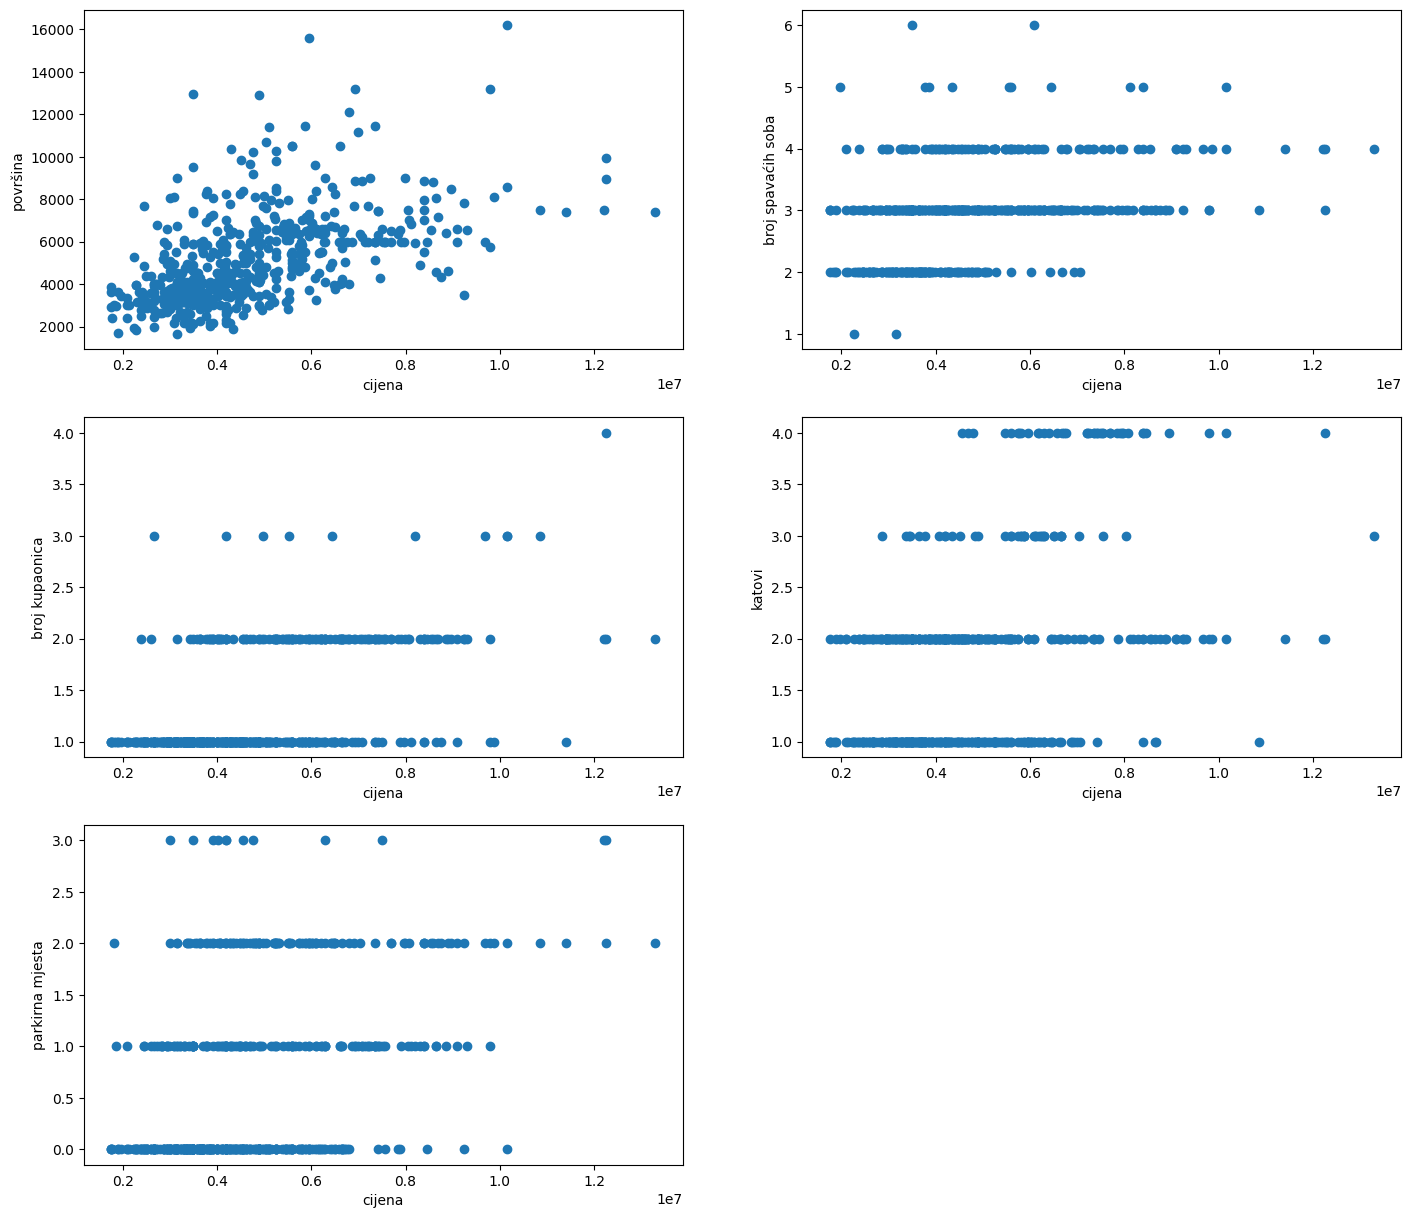

In [12]:
plt.figure(figsize=(17,15))

plt.subplot(3,2,1)
plt.scatter(df['price'], df['area'])
plt.xlabel("cijena")
plt.ylabel("površina")

plt.subplot(3,2,2)
plt.scatter(df['price'], df['bedrooms'])
plt.xlabel("cijena")
plt.ylabel("broj spavaćih soba")

plt.subplot(3,2,3)
plt.scatter(df['price'], df['bathrooms'])
plt.xlabel("cijena")
plt.ylabel("broj kupaonica")

plt.subplot(3,2,4)
plt.scatter(df['price'], df['stories'])
plt.xlabel("cijena")
plt.ylabel("katovi")

plt.subplot(3,2,5)
plt.scatter(df['price'], df['parking'])
plt.xlabel("cijena")
plt.ylabel("parkirna mjesta")


Površina je kontinuirana varijabla, dok su ostale diskretne. Veća površina obično znači veća cijena stana, iako postoje iznimke. Manji broj spavaćih soba najčešće znači manja cijena (iako također postoje iznimke, moguće da su sobe u lošijem stanju), dok je za veći broj soba raspon širok. Prema ostalim grafovima teško je procijeniti povezanost.

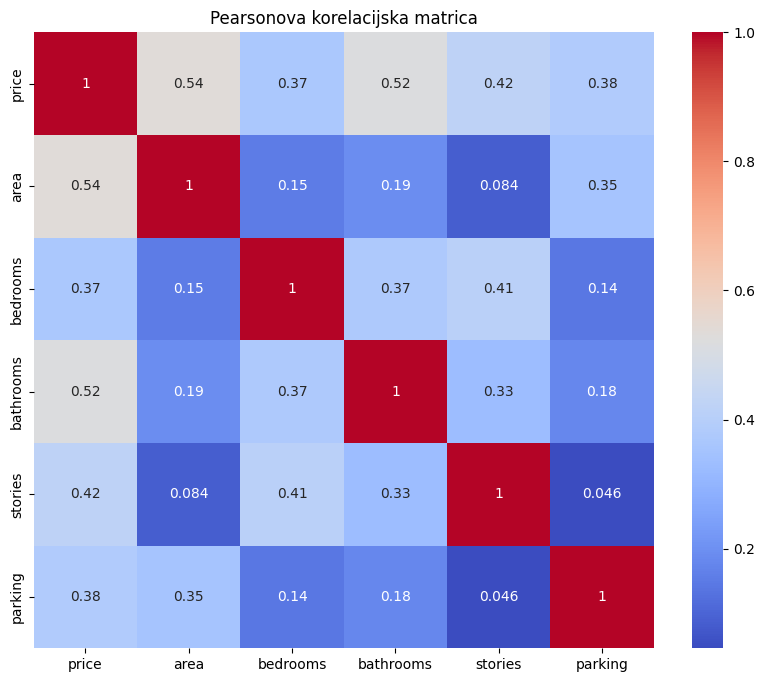

In [14]:
num_cols = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

corr_pearson = df[num_cols].corr(method="pearson")

plt.figure(figsize=(10,8))
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm')
plt.title("Pearsonova korelacijska matrica")
plt.show()

Iz dobivene matrice možemo vidjeti kako imamo srednje visoku korelaciju između cijene i površine što se čini normalnim. Također broj kupaonica pokazuje pozitivnu korelaciju s cijenom. Broj spavaćih soba ima najmanji iznos korelacije s cijenom (0.37).

# 3. Priprema varijabli za višestruku regresiju

In [28]:
y = df[['price']]

binary = ['mainroad', 'guestroom', 'basement','hotwaterheating', 'airconditioning']
df['mainroad'] = df['mainroad'].map({'yes': 1, 'no': 0})
df['guestroom'] = df['guestroom'].map({'yes': 1, 'no': 0})
df['basement'] = df['basement'].map({'yes': 1, 'no': 0})
df['hotwaterheating'] = df['hotwaterheating'].map({'yes': 1, 'no': 0})
df['airconditioning'] = df['airconditioning'].map({'yes': 1, 'no': 0})
df['prefarea'] = df['prefarea'].map({'yes': 1, 'no': 0})
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


Mapiranje kategorija u binarni zapis za lakši rad sa podatcima

In [29]:
df_encoded = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=False)

df_encoded = df_encoded.rename(columns={'furnishingstatus_furnished': 'furnished', 'furnishingstatus_semi-furnished': 'semi-furnished', 'furnishingstatus_unfurnished': 'unfurnished'})

df_encoded.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,True,False,False
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,True,False,False
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,False,True,False
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,True,False,False
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,True,False,False


Rastavljanje 'furnishingstatus' na 3 stupca



In [30]:
df_encoded['semi-furnished'] = df_encoded['semi-furnished'].map({True: 1, False: 0})
df_encoded['unfurnished'] = df_encoded['unfurnished'].map({True: 1, False: 0})
df_encoded['furnished'] = df_encoded['furnished'].map({True: 1, False: 0})

df_encoded.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0,0


Ponocno mapirarnje na binarnu razinu

In [31]:

df_selected = df_encoded
df_selected = df_encoded = df_encoded.drop('price', axis=1)
df_selected.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished,semi-furnished,unfurnished
0,7420,4,2,3,1,0,0,0,1,2,1,1,0,0
1,8960,4,4,4,1,0,0,0,1,3,0,1,0,0
2,9960,3,2,2,1,0,1,0,0,2,1,0,1,0
3,7500,4,2,2,1,0,1,0,1,3,1,1,0,0
4,7420,4,1,2,1,1,1,0,1,2,0,1,0,0


Micanje stupca 'price' iz dataseta jer njega predviđamo

In [32]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_selected.columns
vif_data["VIF"] = [
    variance_inflation_factor(df_selected.values, i)
    for i in range(len(df_selected.columns))
]
print(vif_data)



            feature        VIF
0              area   1.325250
1          bedrooms   1.369477
2         bathrooms   1.286621
3           stories   1.478055
4          mainroad   1.172728
5         guestroom   1.212838
6          basement   1.323050
7   hotwaterheating   1.041506
8   airconditioning   1.211840
9           parking   1.212837
10         prefarea   1.149196
11        furnished   8.575840
12   semi-furnished  12.404306
13      unfurnished   8.826219


Ovdje sad gledamo koji stupac ima najveći VIF, potom ga izbacujemo i ponovno provjeravmamo VIF, kada vidimo da se stabiliziralo onda stajemo i nastavljemo sa modelom. Na taj način si osiguravamo dobar koeficijent determinacije

U ovom prvom slučaju bi trebali izbaciti semi-furnished

In [33]:
df_selected = df_selected.drop('semi-furnished', axis=1)

In [34]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_selected.columns
vif_data["VIF"] = [
    variance_inflation_factor(df_selected.values, i)
    for i in range(len(df_selected.columns))
]
print(vif_data)


            feature        VIF
0              area   8.280287
1          bedrooms  15.668590
2         bathrooms   9.413944
3           stories   7.884697
4          mainroad   6.853701
5         guestroom   1.470778
6          basement   2.017734
7   hotwaterheating   1.091392
8   airconditioning   1.757763
9           parking   1.979708
10         prefarea   1.489285
11        furnished   1.650160
12      unfurnished   1.664680


In [35]:
df_selected = df_selected.drop('bedrooms', axis=1)

In [36]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_selected.columns
vif_data["VIF"] = [
    variance_inflation_factor(df_selected.values, i)
    for i in range(len(df_selected.columns))
]
print(vif_data)

            feature       VIF
0              area  7.641659
1         bathrooms  7.848594
2           stories  6.267661
3          mainroad  6.678221
4         guestroom  1.464085
5          basement  1.903539
6   hotwaterheating  1.090327
7   airconditioning  1.748472
8           parking  1.979317
9          prefarea  1.486973
10        furnished  1.644426
11      unfurnished  1.613560


Nakon OLS-a vidimo da je p-vrijednost visoka kod furnished

In [37]:
df_selected = df_selected.drop('furnished', axis=1)

In [38]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_selected.columns
vif_data["VIF"] = [
    variance_inflation_factor(df_selected.values, i)
    for i in range(len(df_selected.columns))
]
print(vif_data)

            feature       VIF
0              area  7.592945
1         bathrooms  7.809742
2           stories  6.247597
3          mainroad  6.603460
4         guestroom  1.463299
5          basement  1.902385
6   hotwaterheating  1.089976
7   airconditioning  1.737582
8           parking  1.978610
9          prefarea  1.486231
10      unfurnished  1.404308


Prvo smo računali VIF sa svim stupcima, promatrali smo koji se stupac ističe po VIF vrijednosti (>10), te ga izbacili. Potom smo izbacili semi-furnished,spavaće pa kupaonice. Nakon toga VIF vrijednosti ne prelaze 8. Povrsinu i kupaonice ne bih micao jer smatram da imaju snažnu vezu s određivanjem cijene.

# 4.  Postavljanje modela višestruke linearne regresije (statsmodels)

In [39]:
x = df_selected
print(x.head())
print(y.head())

   area  bathrooms  stories  mainroad  guestroom  basement  hotwaterheating  \
0  7420          2        3         1          0         0                0   
1  8960          4        4         1          0         0                0   
2  9960          2        2         1          0         1                0   
3  7500          2        2         1          0         1                0   
4  7420          1        2         1          1         1                0   

   airconditioning  parking  prefarea  unfurnished  
0                1        2         1            0  
1                1        3         0            0  
2                0        2         1            0  
3                1        3         1            0  
4                1        2         0            0  
      price
0  13300000
1  12250000
2  12250000
3  12215000
4  11410000


In [41]:
X_const = sm.add_constant(x)
model = sm.OLS(y, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     103.1
Date:                Fri, 16 Jan 2026   Prob (F-statistic):          3.24e-124
Time:                        11:43:00   Log-Likelihood:                -8332.9
No. Observations:                 545   AIC:                         1.669e+04
Df Residuals:                     533   BIC:                         1.674e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.336e+05   2.02e+05     

Jednadžba: y = 2.336e+05 + 247.46 * area + 1.025 * bathrooms...

R2 - 68% varijabilnosti u cijeni objašnjeno je odabranim ulaznim varijablama. Adj. R2 - predstavlja sličnu stvar kao R2, ali penalizira nepotrebne varijable.

# 5.  Provjera pretpostavki i vizualizacija rezultata

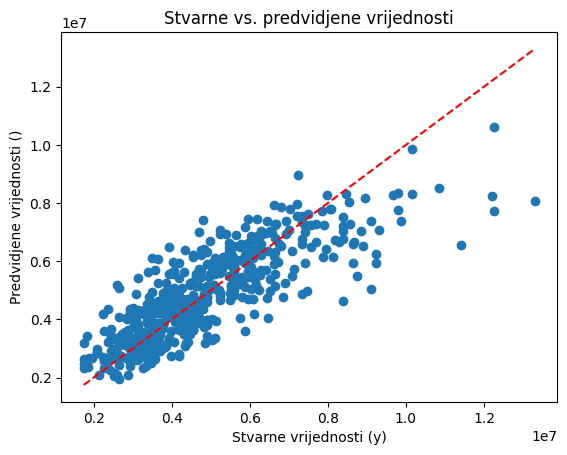

In [42]:
df["pred"] = model.fittedvalues
df["resid"] = model.resid

y_pred = model.predict(X_const)

plt.scatter(y, y_pred)
plt.xlabel("Stvarne vrijednosti (y)")
plt.ylabel("Predvidjene vrijednosti ()")
plt.title("Stvarne vs. predvidjene vrijednosti")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.show()

Na grafu vidimo da je predviđanje najbolje u rasponu od početka do 0.7e+07, nakon toga točke dosta odstupaju.

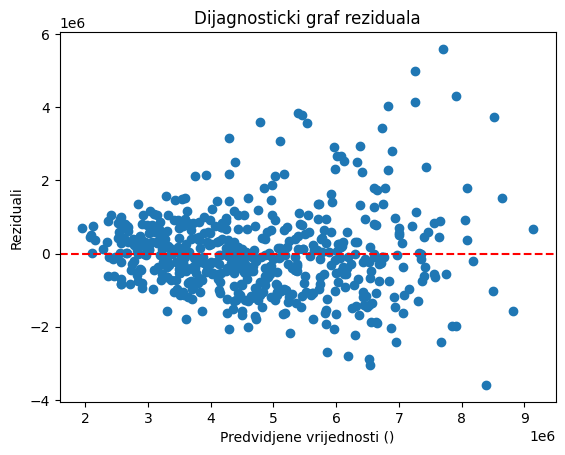

In [ ]:
resid = y - y_pred
plt.scatter(y_pred, df["resid"])
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predvidjene vrijednosti ()")
plt.ylabel("Reziduali")
plt.title("Dijagnosticki graf reziduala")
plt.show()


# Ima oblik lijevka koji se širi prema desnoj strani. Smatram da nije prisutna homoskedastičnost jer reziduali na grafu ne izgledaju nasumično raspoređeno.

Vidimo kako tocke nisu pravino raspoređene duž pravca pa iz toga možemo zaključiti kako se radi o heteroskedastičnosti (varijanca (raspršenje) grešaka (reziduala) u regresijskom modelu nije konstantna za sve razine neovisnih varijabli).

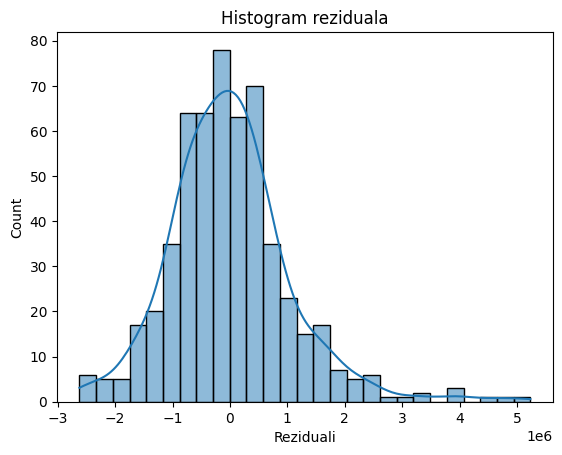

In [43]:
sns.histplot(df["resid"], kde=True)
plt.xlabel('Reziduali')
plt.title('Histogram reziduala')
plt.show()

# Distribucija reziduala je normalna.

Distribucija reziduala je skoro pa normalna.

# 6. Primjena modela i zaključak

In [44]:
x.head()

,area,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,unfurnished
0,7420,2,3,1,0,0,0,1,2,1,0
1,8960,4,4,1,0,0,0,1,3,0,0
2,9960,2,2,1,0,1,0,0,2,1,0
3,7500,2,2,1,0,1,0,1,3,1,0
4,7420,1,2,1,1,1,0,1,2,0,0


In [53]:

y_pred = model.predict([[1, 7420, 2, 3, 1, 0, 0, 0, 1, 2, 1, 0]])

print(y_pred)

[8068302.513136]


Cijena ima najveću korelaciju s površinom i brojem kupaonica (pozitivnu - veće vrijednosti tih stupaca znače veću cijenu).